In [1]:
import json
import pandas as pd
import os
import re
import cv2
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import TensorBoard

# Data Pre-Processing

In [4]:
pip install transformers pillow 

Note: you may need to restart the kernel to use updated packages.


In [2]:
import tensorflow as tf

# Check if TensorFlow detects the GPU
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [ ]:
pip install --upgrade tensorflow==2.13

In [ ]:
pip install keras

In [2]:
import json
import pandas as pd
import re
from transformers import pipeline
import torch
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from PIL import Image
import numpy as np
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import keras_tuner as kt 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Path to the JSON annotation file
json_file_path = '/kaggle/input/iuxray/iu_xray/annotation.json'

# Load the JSON data
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Extract train, test, and val splits
train_data = data.get('train', [])
test_data = data.get('test', [])
val_data = data.get('val', [])

# Convert each split to a Pandas DataFrame
train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)
val_df = pd.DataFrame(val_data)

# Display the first few rows of each DataFrame to verify
print("Training DataFrame:")
print(train_df.head())

print("\nTesting DataFrame:")
print(test_df.head())

print("\nValidation DataFrame:")
print(val_df.head())


Training DataFrame:
                id                                             report  \
0  CXR2384_IM-0942  The heart size and pulmonary vascularity appea...   
1  CXR2926_IM-1328  Cardiac and mediastinal contours are within no...   
2  CXR1451_IM-0291  Left lower lobe calcified granuloma. Heart siz...   
3  CXR2887_IM-1289  The cardiomediastinal silhouette is normal in ...   
4  CXR1647_IM-0424  The lungs are clear bilaterally. Specifically,...   

                                       image_path  split  
0  [CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]  train  
1  [CXR2926_IM-1328/0.png, CXR2926_IM-1328/1.png]  train  
2  [CXR1451_IM-0291/0.png, CXR1451_IM-0291/1.png]  train  
3  [CXR2887_IM-1289/0.png, CXR2887_IM-1289/1.png]  train  
4  [CXR1647_IM-0424/0.png, CXR1647_IM-0424/1.png]  train  

Testing DataFrame:
                id                                             report  \
0  CXR3030_IM-1405  Normal cardiomediastinal silhouette. There is ...   
1    CXR38_IM-1911  L

In [4]:
train_df

,id,report,image_path,split
0,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,"[CXR2384_IM-0942/0.png, CXR2384_IM-0942/1.png]",train
1,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,"[CXR2926_IM-1328/0.png, CXR2926_IM-1328/1.png]",train
2,CXR1451_IM-0291,Left lower lobe calcified granuloma. Heart siz...,"[CXR1451_IM-0291/0.png, CXR1451_IM-0291/1.png]",train
3,CXR2887_IM-1289,The cardiomediastinal silhouette is normal in ...,"[CXR2887_IM-1289/0.png, CXR2887_IM-1289/1.png]",train
4,CXR1647_IM-0424,"The lungs are clear bilaterally. Specifically,...","[CXR1647_IM-0424/0.png, CXR1647_IM-0424/1.png]",train
...,...,...,...,...
2064,CXR1600_IM-0390,The lungs are clear. There is no focal airspac...,"[CXR1600_IM-0390/0.png, CXR1600_IM-0390/1.png]",train
2065,CXR2465_IM-0997,Heart size is mildly enlarged but stable.. The...,"[CXR2465_IM-0997/0.png, CXR2465_IM-0997/1.png]",train
2066,CXR1595_IM-0386,The heart is large. Lung volumes are XXXX. XXX...,"[CXR1595_IM-0386/0.png, CXR1595_IM-0386/1.png]",train
2067,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,"[CXR911_IM-2417/0.png, CXR911_IM-2417/1.png]",train


In [5]:
# Define the list of 14 diseases
diseases = [
    'Enlarged Cardiomediastinum',
    'Cardiomegaly',
    'Lung Opacity',
    'Lung Lesion',
    'Edema',
    'Consolidation',
    'Pneumonia',
    'Atelectasis',
    'Pneumothorax',
    'Pleural Effusion',
    'Pleural Other',
    'Fracture',
    'Support Devices',
    'No Finding'
]

# Define possible statuses
statuses = ['No Mention', 'Positive', 'Negative', 'Uncertain']

In [6]:
csv_file_path = '/kaggle/input/iuxraylabelled/train_labeled_reports.csv'
processed_train_df = pd.read_csv(csv_file_path)

csv_file_path = '/kaggle/input/iuxraylabelled/val_labeled_reports.csv'
processed_val_df = pd.read_csv(csv_file_path)

csv_file_path = '/kaggle/input/iuxraylabelled/test_labeled_reports.csv'
processed_test_df = pd.read_csv(csv_file_path)

In [7]:
# Remove square brackets from the image_path column
processed_train_df['image_path'] = processed_train_df['image_path'].str.replace(r"[\[\]']", '', regex=True)
processed_val_df['image_path'] = processed_val_df['image_path'].str.replace(r"[\[\]']", '', regex=True)
processed_test_df['image_path'] = processed_test_df['image_path'].str.replace(r"[\[\]']", '', regex=True)

In [8]:
def separate_and_append_path(df, root_dir):
    """
    Separates multiple image paths into individual rows and appends the root directory to each image_path.
    
    Parameters:
        df (pd.DataFrame): The DataFrame to process. Must contain 'id' and 'image_path' columns.
        root_dir (str): The root directory to prepend to each image path.
        
    Returns:
        pd.DataFrame: The processed DataFrame with separated image paths and updated paths.
    """
    # Ensure 'image_path' is a list. If it's a string, split by comma and strip spaces.
    if df['image_path'].dtype == object and isinstance(df['image_path'].iloc[0], str):
        df['image_path'] = df['image_path'].apply(lambda x: [path.strip() for path in x.split(',')])
    
    # Explode the 'image_path' column to have one image per row
    df = df.explode('image_path').reset_index(drop=True)
    
    # Append the root directory and 'id' to each image_path
    df['image_path'] = df.apply(lambda row: os.path.join(root_dir, row['image_path']), axis=1)
    
    return df

# Define the root directory in your Kaggle environment
root_directory = "/kaggle/input/iuxray/iu_xray/images"

# Apply the function to all three DataFrames
processed_train_df = separate_and_append_path(processed_train_df, root_directory)
processed_val_df = separate_and_append_path(processed_val_df, root_directory)
processed_test_df = separate_and_append_path(processed_test_df, root_directory)


In [9]:
processed_train_df

,id,report,image_path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,/kaggle/input/iuxray/iu_xray/images/CXR2384_IM...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
1,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,/kaggle/input/iuxray/iu_xray/images/CXR2384_IM...,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN
2,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,/kaggle/input/iuxray/iu_xray/images/CXR2926_IM...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
3,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,/kaggle/input/iuxray/iu_xray/images/CXR2926_IM...,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,CXR1451_IM-0291,Left lower lobe calcified granuloma. Heart siz...,/kaggle/input/iuxray/iu_xray/images/CXR1451_IM...,NaN,0.0,NaN,NaN,NaN,NaN,NaN,1.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,CXR1595_IM-0386,The heart is large. Lung volumes are XXXX. XXX...,/kaggle/input/iuxray/iu_xray/images/CXR1595_IM...,NaN,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4134,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,/kaggle/input/iuxray/iu_xray/images/CXR911_IM-...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0
4135,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,/kaggle/input/iuxray/iu_xray/images/CXR911_IM-...,0.0,0.0,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,1.0
4136,CXR3835_IM-1938,Lungs are clear bilaterally. There is no focal...,/kaggle/input/iuxray/iu_xray/images/CXR3835_IM...,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN


In [11]:
processed_train_df.fillna(2, inplace=True)
processed_test_df.fillna(2, inplace=True)
processed_val_df.fillna(2, inplace=True)

In [12]:
processed_train_df

,id,report,image_path,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,No Finding
0,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,/kaggle/input/iuxray/iu_xray/images/CXR2384_IM...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0
1,CXR2384_IM-0942,The heart size and pulmonary vascularity appea...,/kaggle/input/iuxray/iu_xray/images/CXR2384_IM...,2.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0
2,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,/kaggle/input/iuxray/iu_xray/images/CXR2926_IM...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
3,CXR2926_IM-1328,Cardiac and mediastinal contours are within no...,/kaggle/input/iuxray/iu_xray/images/CXR2926_IM...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0
4,CXR1451_IM-0291,Left lower lobe calcified granuloma. Heart siz...,/kaggle/input/iuxray/iu_xray/images/CXR1451_IM...,2.0,0.0,2.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4133,CXR1595_IM-0386,The heart is large. Lung volumes are XXXX. XXX...,/kaggle/input/iuxray/iu_xray/images/CXR1595_IM...,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
4134,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,/kaggle/input/iuxray/iu_xray/images/CXR911_IM-...,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
4135,CXR911_IM-2417,Heart size within normal limits and cardiomedi...,/kaggle/input/iuxray/iu_xray/images/CXR911_IM-...,0.0,0.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,1.0
4136,CXR3835_IM-1938,Lungs are clear bilaterally. There is no focal...,/kaggle/input/iuxray/iu_xray/images/CXR3835_IM...,2.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,2.0,2.0,2.0


In [13]:
diseases = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity', 'Lung Lesion',
            'Edema', 'Consolidation', 'Pneumonia', 'Atelectasis', 'Pneumothorax',
            'Pleural Effusion', 'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']
# Define image size and other parameters
IMAGE_SIZE = (224, 224)  # Common size for CNNs like ResNet
BATCH_SIZE = 32
NUM_CLASSES = 4  # No Mention, Uncertain Mention, Positive Mention, Negative Mention

# Create a mapping for statuses to numerical labels
status_mapping = {
    'NaN': 2,
    }

def encode_labels(df, diseases, status_mapping):
    """
    Encodes the disease statuses into numerical labels.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing disease status columns.
        diseases (list): List of diseases.
        status_mapping (dict): Mapping from status values to numerical labels.
    
    Returns:
        np.array: Encoded labels for each disease.
    """
    label_arrays = []
    for disease in diseases:
        labels = df[disease]
        label_arrays.append(labels)
    # Stack labels for multi-label classification
    labels = np.stack(label_arrays, axis=1)
    return labels

# Encode labels for each split
train_labels = encode_labels(processed_train_df, diseases, status_mapping)
test_labels = encode_labels(processed_test_df, diseases, status_mapping)
val_labels = encode_labels(processed_val_df, diseases, status_mapping)

# Function to load and preprocess images
def load_and_preprocess_image(path):
    """
    Loads an image from a given path and preprocesses it.
    
    Parameters:
        path (str): Path to the image file.
    
    Returns:
        np.array: Preprocessed image.
    """
    try:
        img = Image.open(path).convert('L')  # Convert to grayscale
        img = img.resize(IMAGE_SIZE)
        img = np.array(img)
        img = np.expand_dims(img, axis=-1)  # Add channel dimension
        img = img / 255.0  # Normalize to [0,1]
        return img
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return np.zeros((*IMAGE_SIZE, 1))  # Return a blank image in case of error

# Vectorized image loading
def load_images(df):
    """
    Loads and preprocesses all images in a DataFrame.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing image paths.
    
    Returns:
        np.array: Array of preprocessed images.
    """
    images = df['image_path'].apply(load_and_preprocess_image)
    return np.stack(images.values)

# Load images for each split
train_images = load_images(processed_train_df)
test_images = load_images(processed_test_df)
val_images = load_images(processed_val_df)

print(f"Train images shape: {train_images.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Validation images shape: {val_images.shape}")


Train images shape: (4138, 224, 224, 1)
Test images shape: (1180, 224, 224, 1)
Validation images shape: (592, 224, 224, 1)


In [14]:
train_labels.shape

(4138, 14)

In [15]:
# Number of diseases
NUM_DISEASES = len(diseases)

# Input shape
input_shape = (*IMAGE_SIZE, 1)  # Grayscale images

# Prepare labels for the model
# Each disease has its own label array
train_labels_list = [train_labels[:, i] for i in range(NUM_DISEASES)]
test_labels_list = [test_labels[:, i] for i in range(NUM_DISEASES)]
val_labels_list = [val_labels[:, i] for i in range(NUM_DISEASES)]

# One-hot encode the labels
train_labels_ohe = [to_categorical(label, num_classes=NUM_CLASSES) for label in train_labels_list]
test_labels_ohe = [to_categorical(label, num_classes=NUM_CLASSES) for label in test_labels_list]
val_labels_ohe = [to_categorical(label, num_classes=NUM_CLASSES) for label in val_labels_list]

In [ ]:
# Ensure reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# ---------------------------
# Define Hyperparameters for Tuning
# ---------------------------

def build_model(hp):
    """
    Builds and compiles a Keras model with hyperparameters to tune.

    Parameters:
        hp (keras_tuner.HyperParameters): Hyperparameters to tune.

    Returns:
        model (tf.keras.Model): Compiled Keras model.
    """
    # Define the input layer
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name='input_layer')
    
    # Data Augmentation Layers
    x = layers.RandomFlip("horizontal")(inputs)
    x = layers.RandomRotation(0.1)(x)
    x = layers.RandomZoom(0.1)(x)
    
    # Convert grayscale to 3 channels by repeating the single channel
    x = layers.Concatenate(name='concat_channels')([x, x, x])
    
    # Build the base model using ResNet50 (without the top classification layers)
    base_model = ResNet50(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    )
    
    # Freeze the base model
    base_model.trainable = False
    
    # Pass through the base model
    x = base_model(x, training=False)
    
    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)
    
    # Hyperparameter: Number of units in the Dense layer
    dense_units = hp.Int('dense_units', min_value=512, max_value=2048, step=512, default=1024)
    x = layers.Dense(
        dense_units,
        activation='relu',
        kernel_regularizer=regularizers.l2(hp.Float('l2_reg', min_value=1e-5, max_value=1e-3, sampling='LOG', default=1e-4)),
        name='dense_layer'
    )(x)
    
    # Hyperparameter: Dropout rate
    dropout_rate = hp.Float('dropout_rate', min_value=0.3, max_value=0.7, step=0.1, default=0.5)
    x = layers.Dropout(dropout_rate, name='dropout_layer')(x)
    
    # Define separate outputs for each disease
    outputs = []
    for i in range(NUM_DISEASES):
        output = layers.Dense(
            NUM_CLASSES,
            activation='softmax',
            name=f'disease_{i}'
        )(x)
        outputs.append(output)
    
    # Define the model
    model = models.Model(inputs=inputs, outputs=outputs, name='Disease_Classifier_Model')
    
    # Hyperparameter: Learning rate
    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5], default=1e-4)
    
    # Compile the model
    # Compile the model with unique metrics
    metrics = {f'disease_{i}': ['accuracy'] for i in range(NUM_DISEASES)}
    model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss={f'disease_{i}': 'categorical_crossentropy' for i in range(NUM_DISEASES)},
    metrics=metrics
    )

    return model

# ---------------------------
# Initialize the Hyperparameter Tuner
# ---------------------------

# Instantiate the tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='kt_dir',
    project_name='disease_classification'
)

# ---------------------------
# Define Callbacks for Hyperparameter Tuning
# ---------------------------

stop_early = EarlyStopping(monitor='val_loss', patience=3)

# ---------------------------
# Perform Hyperparameter Search
# ---------------------------

tuner.search(
    train_images,
    train_labels_ohe,
    epochs=20,
    batch_size=BATCH_SIZE,
    validation_data=(val_images, val_labels_ohe),
    callbacks=[stop_early]
)

# ---------------------------
# Retrieve the Best Hyperparameters
# ---------------------------

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Hyperparameter Tuning Complete.
Optimal number of units in dense layer: {best_hps.get('dense_units')}
Optimal dropout rate: {best_hps.get('dropout_rate')}
Optimal L2 regularization: {best_hps.get('l2_reg')}
Optimal learning rate: {best_hps.get('learning_rate')}
""")


# ---------------------------
# Build the Model with Best Hyperparameters
# ---------------------------

model = tuner.hypermodel.build(best_hps)

Trial 24 Complete [01h 02m 27s]
val_loss: 7.04432487487793

Best val_loss So Far: 7.023255825042725
Total elapsed time: 09h 48m 41s

Search: Running Trial #25

Value             |Best Value So Far |Hyperparameter
1536              |1024              |dense_units
0.00036573        |1.1572e-05        |l2_reg
0.4               |0.3               |dropout_rate
1e-05             |0.0001            |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/20
130/130 [==============================] - 320s 2s/step - loss: 14.6824 - disease_0_loss: 1.1610 - disease_1_loss: 1.1277 - disease_2_loss: 1.1455 - disease_3_loss: 0.9343 - disease_4_loss: 0.8470 - disease_5_loss: 1.1763 - disease_6_loss: 0.7039 - disease_7_loss: 0.8262 - disease_8_loss: 1.3247 - disease_9_loss: 1.2748 - disease_10_loss: 0.2467 - disease_11_loss:

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Hyperparameters obtained from the tuner
dense_units = 1536
l2_reg = 0.00036573
dropout_rate = 0.4
learning_rate = 1e-5

# Image size and number of diseases/classes (set these as per your data)
IMAGE_SIZE = (224, 224)  # Change based on your image input size
# NUM_DISEASES = 3  # Update based on the number of diseases
# NUM_CLASSES = 5  # Update based on the number of classes for each disease (e.g., 5 classes)

# Build the model
inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1), name='input_layer')

# Data Augmentation Layers
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)
x = layers.RandomZoom(0.1)(x)

# Convert grayscale to 3 channels by repeating the single channel
x = layers.Concatenate(name='concat_channels')([x, x, x])

# Build the base model using ResNet50 (without the top classification layers)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
)

# Freeze the base model
base_model.trainable = False

# Pass through the base model
x = base_model(x, training=False)

# Global Average Pooling
x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

# Dense layer with L2 regularization
x = layers.Dense(
    dense_units,
    activation='relu',
    kernel_regularizer=regularizers.l2(l2_reg),
    name='dense_layer'
)(x)

# Dropout layer
x = layers.Dropout(dropout_rate, name='dropout_layer')(x)

# Define separate outputs for each disease
outputs = []
for i in range(NUM_DISEASES):
    output = layers.Dense(
        NUM_CLASSES,
        activation='softmax',
        name=f'disease_{i}'
    )(x)
    outputs.append(output)

# Define the model
model = models.Model(inputs=inputs, outputs=outputs, name='Disease_Classifier_Model')

# Compile the model with the best learning rate
model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss={f'disease_{i}': 'categorical_crossentropy' for i in range(NUM_DISEASES)},
    metrics={f'disease_{i}': ['accuracy'] for i in range(NUM_DISEASES)}
)

# Print model summary
model.summary()

# Define EarlyStopping callback
stop_early = EarlyStopping(monitor='val_loss', patience=3)




Model: "Disease_Classifier_Model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_flip_1       │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (RandomFlip)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_rotation_1   │ (None, 224, 224,  │          0 │ random_flip_1[0]… │
│ (RandomRotation)    │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_zoom_1       │ (None, 224, 224,  │          0 │ random_rotation_… │
│ (RandomZoom)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat_channels     │ (None, 224, 224,  │          0 │ random_zoom_1[0]… │
│ (Concatenate)       │ 3)                │            │ random_zoom_1[0]… │
│                     │                   │            │ random_zoom_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ concat_channels[… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_avg_pool     │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_layer (Dense) │ (None, 1536)      │  3,147,264 │ global_avg_pool[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_layer       │ (None, 1536)      │          0 │ dense_layer[0][0] │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_0 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_1 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_2 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_3 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_4 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_5 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_6 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_7 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_8 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_9 (Dense)   │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ disease_10 (Dense)  │ (None, 4)         │      6,148 │ dropout_layer[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 26,821,048 (102.31 MB)

 Trainable params: 3,233,336 (12.33 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/20
130/130 ━━━━━━━━━━━━━━━━━━━━ 36s 189ms/step - disease_0_accuracy: 0.4465 - disease_10_accuracy: 0.5611 - disease_11_accuracy: 0.4893 - disease_12_accuracy: 0.4998 - disease_13_accuracy: 0.3360 - disease_1_accuracy: 0.2845 - disease_2_accuracy: 0.2713 - disease_3_accuracy: 0.6562 - disease_4_accuracy: 0.4638 - disease_5_accuracy: 0.0305 - disease_6_accuracy: 0.1774 - disease_7_accuracy: 0.5008 - disease_8_accuracy: 0.3769 - disease_9_accuracy: 0.1370 - loss: 20.5991 - val_disease_0_accuracy: 0.5439 - val_disease_10_accuracy: 0.9865 - val_disease_11_accuracy: 0.9054 - val_disease_12_accuracy: 0.9324 - val_disease_13_accuracy: 0.6351 - val_disease_1_accuracy: 0.6689 - val_disease_2_accuracy: 0.7162 - val_disease_3_accuracy: 0.9189 - val_disease_4_accuracy: 0.9358 - val_disease_5_accuracy: 0.5895 - val_disease_6_accuracy: 0.9628 - val_disease_7_accuracy: 0.9493 - val_disease_8_accuracy: 0.7804 - val_disease_9_accuracy: 0.7770 - val_loss: 9.8990
Epoch 2/20
130/130 ━━━━━━━━━━━━━━━

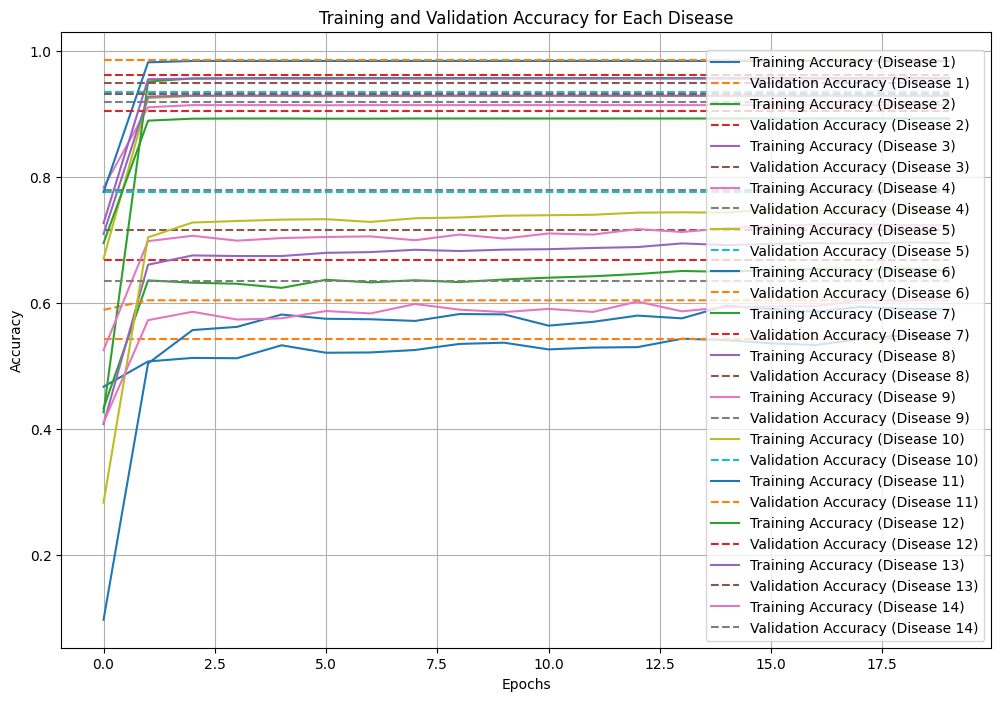

In [18]:
import matplotlib.pyplot as plt

# Train the model and capture the training history
history = model.fit(
    train_images,
    train_labels_ohe,
    epochs=20,
    batch_size=32,
    validation_data=(val_images, val_labels_ohe),
    callbacks=[stop_early]
)

# Extract the accuracy history for each disease
epochs = history.epoch
num_diseases = NUM_DISEASES

# Plot the accuracy for each disease
plt.figure(figsize=(12, 8))

for i in range(num_diseases):
    # Training and validation accuracy for each disease
    plt.plot(epochs, history.history[f'disease_{i}_accuracy'], label=f'Training Accuracy (Disease {i+1})')
    plt.plot(epochs, history.history[f'val_disease_{i}_accuracy'], label=f'Validation Accuracy (Disease {i+1})', linestyle='--')

plt.title("Training and Validation Accuracy for Each Disease")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [20]:
import numpy as np
from sklearn.metrics import accuracy_score

# Predict on the test data
predictions = model.predict(test_images)  # Replace test_images with your actual test data

# Convert predictions to class labels (highest probability)
# predictions is a list of outputs, one for each disease
predicted_labels = [np.argmax(pred, axis=-1) for pred in predictions]

# Compute accuracy for each disease
accuracies = []
for i in range(NUM_DISEASES):
    # Get the true labels for the current disease and the predicted labels
    true_labels = np.argmax(test_labels_ohe[i], axis=-1)  # Convert one-hot to labels for the disease
    disease_pred = predicted_labels[i]  # Predictions for the current disease
    
    # Compute accuracy for this disease
    disease_accuracy = accuracy_score(true_labels, disease_pred)
    accuracies.append(disease_accuracy)

# Print accuracy for each disease
for i, acc in enumerate(accuracies):
    print(f"Accuracy for Disease {i+1}: {acc:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step
Accuracy for Disease 1: 0.6508
Accuracy for Disease 2: 0.6542
Accuracy for Disease 3: 0.7644
Accuracy for Disease 4: 0.9203
Accuracy for Disease 5: 0.9356
Accuracy for Disease 6: 0.6441
Accuracy for Disease 7: 0.9559
Accuracy for Disease 8: 0.9339
Accuracy for Disease 9: 0.7610
Accuracy for Disease 10: 0.7661
Accuracy for Disease 11: 0.9881
Accuracy for Disease 12: 0.8898
Accuracy for Disease 13: 0.9729
Accuracy for Disease 14: 0.4610


In [30]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on the test data
predictions = model.predict(test_images)  # Replace test_images with your actual test data

# Convert predictions to class labels (highest probability)
predicted_labels = [np.argmax(pred, axis=-1) for pred in predictions]

# Initialize lists to store the cumulative true labels and predicted labels
all_true_labels = []
all_pred_labels = []

# Flatten the true labels and predicted labels for all diseases
for i in range(NUM_DISEASES):
    # Get the true labels for the current disease and the predicted labels
    true_labels = np.argmax(test_labels_ohe[i], axis=-1)  # Convert one-hot to labels for the disease
    disease_pred = predicted_labels[i]  # Predictions for the current disease
    
    # Append to the cumulative lists
    all_true_labels.extend(true_labels)
    all_pred_labels.extend(disease_pred)

# Convert the lists to numpy arrays
all_true_labels = np.array(all_true_labels)
all_pred_labels = np.array(all_pred_labels)

# Compute cumulative accuracy
cumulative_accuracy = accuracy_score(all_true_labels, all_pred_labels)

# Compute cumulative precision, recall, and F1 score (using 'macro' for multiclass)
cumulative_precision = precision_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
cumulative_recall = recall_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)
cumulative_f1 = f1_score(all_true_labels, all_pred_labels, average='macro', zero_division=0)

# Print cumulative metrics
print(f"Cumulative Metrics:")
print(f"  Accuracy: {cumulative_accuracy:.4f}")
print(f"  Precision (Macro): {cumulative_precision:.4f}")
print(f"  Recall (Macro): {cumulative_recall:.4f}")
print(f"  F1 Score (Macro): {cumulative_f1:.4f}")


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step
Cumulative Metrics:
  Accuracy: 0.8070
  Precision (Macro): 0.3887
  Recall (Macro): 0.4231
  F1 Score (Macro): 0.4051


In [25]:
import numpy as np

# Select a single record (image) from the test set
sample_index = 11  # Choose any index to view the prediction (0 is the first sample)

# Get the prediction for the selected record
sample_image = test_images[sample_index].reshape(1, *IMAGE_SIZE, 1)  # Reshape if needed
sample_prediction = model.predict(sample_image)

# Convert predictions to class labels (highest probability) for all diseases
predicted_labels = [np.argmax(pred) for pred in sample_prediction]

# Get the true labels for the selected record (for each disease)
true_labels = [np.argmax(test_labels_ohe[i][sample_index], axis=-1) for i in range(NUM_DISEASES)]

# Display the results for each disease
for i in range(NUM_DISEASES):
    print(f"Disease {i + 1}:")
    print(f"  Predicted label: {predicted_labels[i]}")
    print(f"  True label: {true_labels[i]}")
    print('-' * 40)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Disease 1:
  Predicted label: 0
  True label: 0
----------------------------------------
Disease 2:
  Predicted label: 0
  True label: 0
----------------------------------------
Disease 3:
  Predicted label: 2
  True label: 2
----------------------------------------
Disease 4:
  Predicted label: 2
  True label: 0
----------------------------------------
Disease 5:
  Predicted label: 2
  True label: 2
----------------------------------------
Disease 6:
  Predicted label: 2
  True label: 2
----------------------------------------
Disease 7:
  Predicted label: 2
  True label: 2
----------------------------------------
Disease 8:
  Predicted label: 2
  True label: 2
----------------------------------------
Disease 9:
  Predicted label: 0
  True label: 0
----------------------------------------
Disease 10:
  Predicted label: 0
  True label: 0
----------------------------------------
Disease 11:
  Predicted label: 2
  True label: 2
----------------------

In [26]:
import numpy as np

# Select a single record (image) from the test set
sample_index = 50  # Choose any index to view the prediction (0 is the first sample)

# Get the prediction for the selected record
sample_image = test_images[sample_index].reshape(1, *IMAGE_SIZE, 1)  # Reshape if needed
sample_prediction = model.predict(sample_image)

# Convert predictions to class labels (highest probability) for all diseases
predicted_labels = [np.argmax(pred) for pred in sample_prediction]

# Display predicted labels as an array
predicted_labels_array = np.array(predicted_labels)
print("Predicted labels for the sample:", predicted_labels_array)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted labels for the sample: [0 0 2 2 2 2 2 2 0 0 2 2 2 2]


In [27]:
# Save model in Keras format
tf.keras.models.save_model(model, 'disease_classifier_model.keras')


In [32]:
from nltk.translate.bleu_score import sentence_bleu

# Predicted and Generated Sentences
predicted_sentence = "Normal cardiomediastinal silhouette. There is no focal consolidation. There are no XXXX of a large pleural effusion. There is no pneumothorax. There is no acute bony abnormality seen."
generated_sentence = "The imaging results show no significant findings, with no evidence of cardiomegaly, lung lesions, or pleural abnormalities. All observations are within normal limits."

# Tokenize sentences
predicted_tokens = predicted_sentence.split()
generated_tokens = generated_sentence.split()

# Compute BLEU score
bleu_score = sentence_bleu([generated_tokens], predicted_tokens)

# Print the BLEU score
print("BLEU Score:", bleu_score)


BLEU Score: 0.6500593260343692


## Detailed CNN model with hyper parameter tunning.

In [33]:
# Evaluate the model on the test set
test_loss, *test_metrics = model.evaluate(test_images, test_labels_ohe, batch_size=BATCH_SIZE)
print(f"Test Loss: {test_loss}")
for i, disease in enumerate(diseases):
    print(f"Test Accuracy for {disease}: {test_metrics[i]}")

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - disease_0_accuracy: 0.7297 - disease_10_accuracy: 0.9929 - disease_11_accuracy: 0.8776 - disease_12_accuracy: 0.9846 - disease_13_accuracy: 0.3131 - disease_1_accuracy: 0.6480 - disease_2_accuracy: 0.8107 - disease_3_accuracy: 0.9231 - disease_4_accuracy: 0.9269 - disease_5_accuracy: 0.6662 - disease_6_accuracy: 0.9463 - disease_7_accuracy: 0.9583 - disease_8_accuracy: 0.7602 - disease_9_accuracy: 0.7578 - loss: 6.8147
Test Loss: 7.012256622314453
Test Accuracy for Enlarged Cardiomediastinum: 0.6508474349975586
Test Accuracy for Cardiomegaly: 0.988135576248169
Test Accuracy for Lung Opacity: 0.8898305296897888
Test Accuracy for Lung Lesion: 0.9728813767433167
Test Accuracy for Edema: 0.4610169529914856
Test Accuracy for Consolidation: 0.6542372703552246
Test Accuracy for Pneumonia: 0.7644068002700806
Test Accuracy for Atelectasis: 0.9203389883041382
Test Accuracy for Pneumothorax: 0.9355932474136353
Test Accuracy for Pleural Effusion: 0.644067

In [34]:
predictions = model.predict(test_images, batch_size=BATCH_SIZE)

37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step
